Loading FastText model...
Generating document embeddings...


100%|██████████| 18082/18082 [00:00<00:00, 36541.99it/s]


Before SMOTE: Counter({0: 15505, 1: 2577})
After SMOTE: Counter({0: 15505, 1: 15505})
Train/Test Split Complete.
Train Class Distribution: Counter({0: 12404, 1: 12404})
Test Class Distribution: Counter({0: 3101, 1: 3101})
✅ Model saved at `/kaggle/working/random_forest_fasttext_model.joblib`.

📊 Evaluation Summary:
✅ Accuracy  : 0.9028
✅ ROC-AUC   : 0.9641
✅ Classification Report:
               precision    recall  f1-score   support

  non-damage       0.92      0.88      0.90      3101
      damage       0.89      0.93      0.90      3101

    accuracy                           0.90      6202
   macro avg       0.90      0.90      0.90      6202
weighted avg       0.90      0.90      0.90      6202



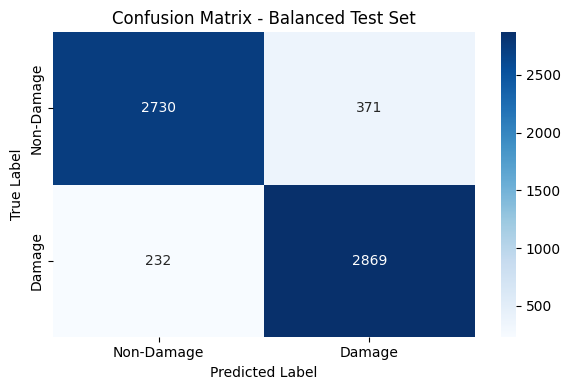

In [22]:
# ========== Imports ==========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import gensim.downloader as api
import joblib
from tqdm import tqdm
from collections import Counter

# ========== Load FastText Model ==========
print("Loading FastText model...")
fasttext_model = api.load("fasttext-wiki-news-subwords-300")
embedding_dim = 300

# ========== Load Dataset ==========
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"
df = pd.read_csv(file_path)

# ========== Preprocess Labels ==========
label_map = {'damage': 1, 'non-damage': 0}
df['Binary_class'] = df['Binary_class'].astype(str).str.strip().str.lower().map(label_map)
df['Processed_data'] = df['Processed_data'].fillna("")

# ========== Generate FastText Embeddings ==========
def get_avg_embedding(text, model, dim):
    words = text.split()
    embeddings = [model[word] for word in words if word in model]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(dim)

print("Generating document embeddings...")
X_embed = np.vstack([get_avg_embedding(text, fasttext_model, embedding_dim) for text in tqdm(df['Processed_data'])])
y = df['Binary_class'].values

# ========== Apply SMOTE (Balance Entire Dataset) ==========
print("Before SMOTE:", Counter(y))
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_embed, y)
print("After SMOTE:", Counter(y_balanced))

# ========== Stratified Train-Test Split on Balanced Data ==========
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)
print("Train/Test Split Complete.")
print("Train Class Distribution:", Counter(y_train))
print("Test Class Distribution:", Counter(y_test))

# ========== Train Random Forest Model ==========
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)

# ========== Save Model ==========
joblib.dump(rf_model, "/kaggle/working/random_forest_fasttext_model.joblib")
print("✅ Model saved at `/kaggle/working/random_forest_fasttext_model.joblib`.")

# ========== Evaluate on Balanced Test Set ==========
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred, target_names=['non-damage', 'damage'])

print("\n📊 Evaluation Summary:")
print(f"✅ Accuracy  : {accuracy:.4f}")
print(f"✅ ROC-AUC   : {roc_auc:.4f}")
print("✅ Classification Report:\n", report)

# ========== Confusion Matrix ==========
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-Damage', 'Damage'],
            yticklabels=['Non-Damage', 'Damage'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Balanced Test Set")
plt.tight_layout()
plt.show()
